In [1]:
import sys
#sys.path.append('/content/drive/My Drive/DQN/input')
sys.path.append('/home/kesci/input')

import math, random
import gym
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from common8945.wrappers import make_atari, wrap_deepmind, wrap_pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()
    
def plot2(frame_idx, rewards, losses, reward_episodes, loss_frames):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx,  np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('frame %s. average loss for every %s frame(s)' % (frame_idx, loss_frames))
    plt.plot(losses)
    plt.show()

In [3]:
#hyper-parameters
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NO_OP = 0
LEARNING_RATE = 0.0000625
GAMMA = 0.99
MEMORY_CAPACITY = 30000
ATOMS_NUM = 51
VMIN = -10.0
VMAX = 10.0
DELTA = 1.0 * (VMAX - VMIN) / (ATOMS_NUM - 1)
TARGET_UPDATE = 1000
EPISODE = 100000
LEARNING_START = 10000
PRINT_START = 20000
LOG_MIN = 0.01
LOG_MAX = 0.99

In [4]:
class ExperienceMemory(object):

    def __init__(self):
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < MEMORY_CAPACITY:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % MEMORY_CAPACITY

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            state, action, reward, next_state, done = self.memory[random.randint(0, self.size() - 1)]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.memory)

In [5]:
class FactorisedGaussianNoise(nn.Module):
  def __init__(self, input, output, init = 0.5):
    super(FactorisedGaussianNoise, self).__init__()
    self.input = input
    self.output = output
    self.mu_w = nn.Parameter(torch.FloatTensor(output, input))
    self.sigma_w = nn.Parameter(torch.FloatTensor(output, input))
    self.register_buffer('eps_w', torch.FloatTensor(output, input))
    self.mu_b = nn.Parameter(torch.FloatTensor(output))
    self.sigma_b = nn.Parameter(torch.FloatTensor(output))
    self.register_buffer('eps_b', torch.FloatTensor(output))
    
    #initialize parameters
    range = 1.0 / math.sqrt(input)
    self.mu_w.data.uniform_(-range, range)
    self.sigma_w.data.fill_(init / math.sqrt(input))
    self.mu_b.data.uniform_(-range, range)
    self.sigma_b.data.fill_(init / math.sqrt(output))
    self.reset()

  def forward(self, x):
    if self.training:
      return F.linear(x, self.mu_w + self.sigma_w * self.eps_w, self.mu_b + self.sigma_b * self.eps_b)
    else:
      return F.linear(x, self.mu_w, self.mu_b)
      
  def reset(self):
    eps_input = self.random_noise(self.input)
    eps_output = self.random_noise(self.output)
    self.eps_w.copy_(eps_output.ger(eps_input))
    self.eps_b.copy_(eps_output)

  def random_noise(self, size):
    res = torch.randn(size)
    return res.sign() * res.abs().sqrt()

In [6]:
class RainbowDQN(nn.Module):

    def __init__(self, input_size, atoms_num, action_space):
        super(RainbowDQN, self).__init__()
        
        self.atoms_num = atoms_num
        self.action_space = action_space
        
        self.conv1 = nn.Conv2d(input_size, 32, kernel_size = 8, stride = 4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)
        
        self.fc_value = FactorisedGaussianNoise(7 * 7 * 64, 512)
        self.output_value = FactorisedGaussianNoise(512, atoms_num)
        
        self.fc_advantage = FactorisedGaussianNoise(7 * 7 * 64, 512)
        self.output_advantage = FactorisedGaussianNoise(512, atoms_num * action_space)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x_value = F.relu(self.fc_value(x.view(x.size(0), -1)))
        x_value = self.output_value(x_value)
        x_value = x_value.view(x.size(0), 1, self.atoms_num)
        
        x_advantage = F.relu(self.fc_advantage(x.view(x.size(0), -1)))
        x_advantage = self.output_advantage(x_advantage)
        x_advantage = x_advantage.view(x.size(0), self.action_space, self.atoms_num)
        
        x = x_value + x_advantage - x_advantage.mean(1, keepdim = True)
        x = F.softmax(x.view(-1, self.atoms_num), dim = 1).view(-1, self.action_space, self.atoms_num)
        
        return x   
    
    def reset(self):
      self.fc_value.reset()
      self.output_value.reset()
      self.fc_advantage.reset()
      self.output_advantage.reset()

    def evaluate(self):
      self.eval()
      self.fc_value.eval()
      self.output_value.eval()
      self.fc_advantage.eval()
      self.output_advantage.eval()

In [7]:
class Agent: 
    def __init__(self, action_space, model_path = None):
        self.action_space = action_space
        self.memory = ExperienceMemory()
        self.policy_net = RainbowDQN(1, ATOMS_NUM, self.action_space).to(DEV)
        self.target_net = RainbowDQN(1, ATOMS_NUM, self.action_space).to(DEV)
        if model_path == None:
            self.play_mode = False
        else:
            self.paly_mode = True
            self.policy_net = torch.load(model_path)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = LEARNING_RATE)
        
    def take_action(self, state):
        with torch.no_grad():
          output = self.policy_net(state)
          z = torch.linspace(VMIN, VMAX, ATOMS_NUM, dtype = torch.float, device = DEV)
          output = output * z
          return output.sum(2).max(1)[1]
    
    def act(self, frame):
        with torch.no_grad():
            state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0) 
            output = self.policy_net(state)
            z = torch.linspace(VMIN, VMAX, ATOMS_NUM, dtype = torch.float, device = DEV)
            output = output * z
            return output.sum(2).max(1)[1]
   
    def optimize(self):
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)
        batch_states = torch.cat(states).to(DEV)
        batch_next_states = torch.cat(next_states).to(DEV)
        batch_actions = torch.tensor(actions, device = DEV, dtype = torch.long)
        batch_rewards = torch.tensor(rewards, device = DEV, dtype = torch.float) 
        batch_dones = torch.tensor(dones, device = DEV, dtype = torch.float)
        
        policy_output = self.policy_net(batch_states)
        policy_action = batch_actions.unsqueeze(1).unsqueeze(1).expand(BATCH_SIZE, 1, ATOMS_NUM)
        policy_value = policy_output.gather(1, policy_action).squeeze(1)
        policy_value.data.clamp_(LOG_MIN, LOG_MAX)
        
        z = torch.linspace(VMIN, VMAX, ATOMS_NUM, dtype = torch.float, device = DEV)
        target_output = self.target_net(batch_next_states) * z
        target_action = target_output.sum(2).max(1)[1]
        target_action = target_action.unsqueeze(1).unsqueeze(1).expand(BATCH_SIZE, 1, ATOMS_NUM)
        target_value = target_output.gather(1, target_action).squeeze(1)
        
        batch_dones = batch_dones.unsqueeze(1).expand(BATCH_SIZE, ATOMS_NUM)
        batch_rewards = batch_rewards.unsqueeze(1).expand(BATCH_SIZE, ATOMS_NUM)
        z = z.unsqueeze(0).expand(BATCH_SIZE, ATOMS_NUM)
        Tz = batch_rewards + GAMMA * (1 - batch_dones) * z
        Tz.clamp_(VMIN, VMAX)
        b  = (Tz - VMIN) / DELTA
        l  = b.floor().long()
        u  = b.ceil().long()
        idx = torch.linspace(0, (BATCH_SIZE - 1) * ATOMS_NUM, BATCH_SIZE, dtype = torch.float, device = DEV).long()
        idx = idx.unsqueeze(1).expand(BATCH_SIZE, ATOMS_NUM)
        m = torch.zeros(BATCH_SIZE * ATOMS_NUM, dtype = torch.float, device = DEV)    
        m.index_add_(0, (l + idx).view(-1), (target_value * (u.float() - b)).view(-1))
        m.index_add_(0, (u + idx).view(-1), (target_value * (b - l.float())).view(-1))
        m = m.view(BATCH_SIZE, ATOMS_NUM)
        loss = -(m * policy_value.log()).sum(1).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.policy_net.reset()
        self.target_net.reset()

        return loss
    
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state.to('cpu'), action.to('cpu'), reward, next_state.to('cpu'), done)

In [8]:
#env_id = "PongNoFrameskip-v4"
#train(env_id, '/home/kesci/work/0510/1/', 1, 1000)
#train(env_id, '/content/drive/My Drive/DQN/0510/1', 5, 5000)
# You may choose the environment from these environment setting below:
# Pong: PongNoFrameskip-v4
# Krull: KrullNoFrameskip-v4
# Tutankham: TutankhamNoFrameskip-v4
# Atlantis: AtlantisNoFrameskip-v4
# Freeway: FreewayNoFrameskip-v4
# Beam Rider: BeamRiderNoFrameskip-v4

## Train Pong (about 400 episodes)

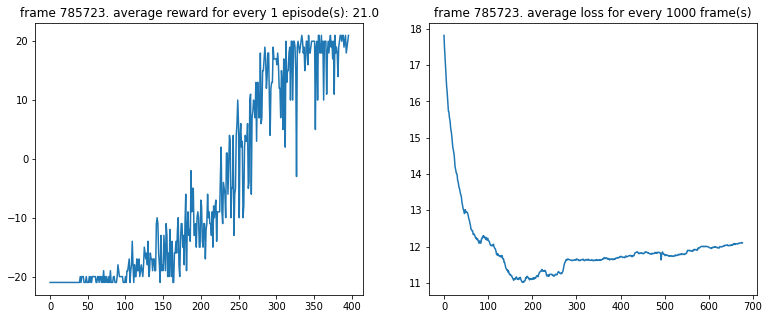

In [0]:
from itertools import count
directory = '/content/drive/My Drive/DQN/0511/4/'
    
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards = False)
env    = wrap_pytorch(env)
agent = Agent(env.action_space.n)
 
all_losses = []
all_rewards = []
frame_idx = 0
reward_episodes = 1
loss_frames = 1000
sum_reward = 0
sum_loss = 0

for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0) 
    
    for t in count():
        frame_idx += 1
        if t < NO_OP:
            action = torch.tensor(0, device = DEV, dtype = torch.long)
        else:
            action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        loss = 0
        if frame_idx > LEARNING_START:
            loss = agent.optimize()
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if frame_idx > PRINT_START:
            sum_loss += loss
            if frame_idx % loss_frames == 0:
                sum_loss = sum_loss / loss_frames
                all_losses.append(sum_loss)
                sum_loss = 0
        
        if done:
            break
    
    if episode % reward_episodes == 0:
        all_rewards.append(episode_reward)
        plot2(frame_idx, all_rewards, all_losses, reward_episodes, loss_frames)
    
    if episode % 10 == 0:
        torch.save(agent.policy_net, directory + 'network' + str(episode) + '.pth')
        torch.save(agent.policy_net.state_dict(), directory + 'state' + str(episode) + '.pth')
        torch.save(all_rewards, directory + 'reward' + str(episode) + '.pth')
        torch.save(all_losses, directory + 'loss' + str(episode) + '.pth')
          
env.close()

## Evaluate Pong

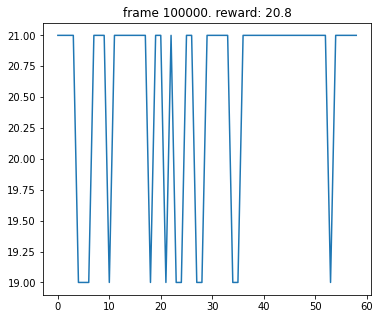

In [0]:
num_frames = 100000

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False)
env    = wrap_pytorch(env)

current_model = Agent(env.action_space.n, model_path = '/content/drive/My Drive/DQN/0511/4/network430.pth')
current_model.policy_net.evaluate()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()

## Train Freeway (about 260 episodes)

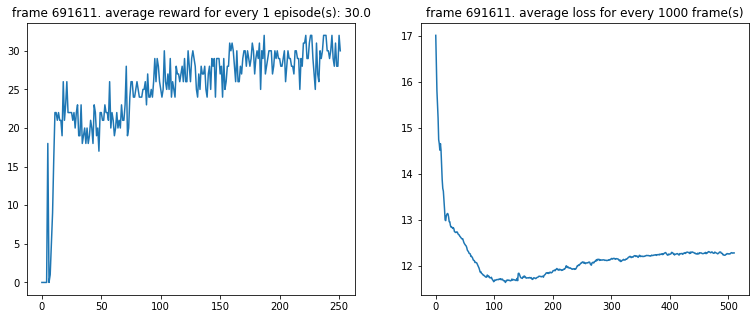

In [0]:
from itertools import count
directory = '/content/drive/My Drive/DQN/0511/5/'
    
env_id = "FreewayNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards = False)
env    = wrap_pytorch(env)
agent = Agent(env.action_space.n)
 
all_losses = []
all_rewards = []
frame_idx = 0
reward_episodes = 1
loss_frames = 1000
sum_reward = 0
sum_loss = 0
   
for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0) 
    
    for t in count():
        frame_idx += 1
        if t < NO_OP:
            action = torch.tensor(0, device = DEV, dtype = torch.long)
        else:
            action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        loss = 0
        if frame_idx > LEARNING_START:
            loss = agent.optimize()
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if frame_idx > PRINT_START:
            sum_loss += loss
            if frame_idx % loss_frames == 0:
                sum_loss = sum_loss / loss_frames
                all_losses.append(sum_loss)
                sum_loss = 0
        
        if done:
            break
    
    if episode % reward_episodes == 0:
        all_rewards.append(episode_reward)
        plot2(frame_idx, all_rewards, all_losses, reward_episodes, loss_frames)
    
    if episode % 10 == 0:
        torch.save(agent.policy_net, directory + 'network' + str(episode) + '.pth')
        torch.save(agent.policy_net.state_dict(), directory + 'state' + str(episode) + '.pth')
        torch.save(all_rewards, directory + 'reward' + str(episode) + '.pth')
        torch.save(all_losses, directory + 'loss' + str(episode) + '.pth')
          
env.close()

## Evaluate Freeway

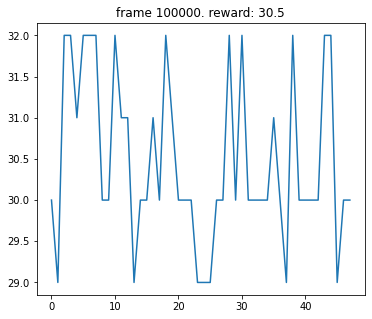

In [14]:
num_frames = 100000

env_id = "FreewayNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False)
env    = wrap_pytorch(env)

current_model = Agent(env.action_space.n, model_path = '/content/drive/My Drive/DQN/0511/5/network260.pth')
current_model.policy_net.evaluate()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()